In [1]:
import os
import numpy as np
from random import shuffle
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD
from tqdm import tqdm

/root/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(2)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 2 NVIDIA GeForce RTX 2080 Ti


In [3]:
IMAGES_PATH = "wg4bpm33hj-2/images"
MASKS_PATH = "wg4bpm33hj-2/masks"
WEIGHT_PATH = "task18"

EPOCHS = 200
BATCH_SIZE = 8
IMAGE_SIZE = 800
LR = 0.001
NUM_SAVE = 5
NK = 8

In [4]:
class CCAgTDataset(Dataset):
    def __init__(self, image_path: str, label_path: str, set_type="train", first_transform=None, sec_transform=None) -> None:
        super().__init__()
        self.first_transform = first_transform
        self.sec_transform = sec_transform
        self.images = []
        self.labels = []
        self.data = []
        self.split_ratio = {"train": (0.0, 0.7), "val": (0.7, 0.8), "test": (0.8, 1.0)}
        self.maxV = 7
        self.mask_ratio = 255 // self.maxV
        
        assert set_type in self.split_ratio.keys(), "dataset type error"
  
        for root, dirs, files in os.walk(image_path):
            for f in files:
                self.images.append(os.path.join(root, f))
                
        for root, dirs, files in os.walk(label_path):
            for f in files:
                self.labels.append(os.path.join(root, f))
                
        assert len(self.images) == len(self.labels), f"data length error, {len(self.images)}, {len(self.labels)}"
        
        for ele in zip(sorted(self.images), sorted(self.labels)):
            self.data.append(ele)
        
        shuffle(self.data)
        self.data = self.data[int(len(self.data)*self.split_ratio[set_type][0]) : int(len(self.data)*self.split_ratio[set_type][1])]
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, mask_path = self.data[index]

        #image = torch.from_numpy(np.array(Image.open(image_path), dtype=np.float64))
        image = Image.open(image_path)
        #mask =  Image.open(mask_path).convert("L")
        mask =  Image.open(mask_path)
        
        if self.first_transform is not None:
            image = self.first_transform(image)
            y = self.first_transform(mask)

        image = transforms.ToTensor()(image)
        y = np.array(y)
        y = torch.from_numpy(y)
        
        y = y.type(torch.LongTensor)
        
        return image, y


In [5]:
# transform = transforms.Compose([
#         transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.NEAREST),
#     ]) 
# trainset = CCAgTDataset(IMAGES_PATH, MASKS_PATH, "train", first_transform=transform)
# x, y = trainset[0]
# print(x.shape, y.shape)
# print(x)
# print(torch.unique(y))
# print(y)

In [6]:
# y = np.random.randint(0, 8, (8, 1, 3, 3))
# z = torch.randint(0, 8, (8, 8, 3, 3)).float()
# #y = torch.clone(z)
# #print(y)
# n = np.zeros((8, 8, 3, 3))

# for i, row in enumerate(y):
#     for j, ele in enumerate(row):
#         print(ele)
#         n[ele][i][j] = 1
# print(n)

# sf = nn.Softmax(1)
# #print(sf(z))
# print(z[0])
# x = torch.argmax(z, axis=1).unsqueeze(1).float()
# print(x[0])

In [7]:
# image_transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#         transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
#     ])
# label_transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
#     ])
# trainset = CCAgTDataset(IMAGES_PATH, MASKS_PATH, "train", image_transform=image_transform, label_transform=label_transform)
# x, y = trainset[0]
# y = y.int()
# print(torch.max(y))
# print(torch.min(y))
# print(y.shape)
# print(x)

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.net(x)
    
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_layer = nn.ConvTranspose2d(in_channels, out_channels, 2, 2)
        self.double_conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x, keep):
        x = self.up_layer(x)
        x = torch.cat([x, keep], dim=1)
        x = self.double_conv(x)
        return x
        

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, hiddens=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList([Up(hidden*2, hidden) for hidden in hiddens[::-1]])
        self.pool = nn.MaxPool2d(2)
        
        for hidden in hiddens:
            self.downs.append(DoubleConv(in_channels, hidden))
            in_channels = hidden
            
        #for hidden in hiddens[::-1]:
        #    self.ups.append(Up(hidden*2, hidden))
            
        self.midden_layer = DoubleConv(hiddens[-1], hiddens[-1]*2)
        self.out_layer = nn.Conv2d(hiddens[0], out_channels, 1)
        #self.sofmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        keeps = []
        
        for down in self.downs:
            x = down(x)
            keeps.append(x)
            x = self.pool(x)
            
        x = self.midden_layer(x)
        keeps = keeps[::-1]
        
        for i, up in enumerate(self.ups):
            x = up(x, keeps[i])
            
        x = self.out_layer(x)
        #x = self.sofmax(x)
        return x
        

In [9]:
# net = UNet(in_channels=3, out_channels=8)
# ins = torch.randn(2, 3, 400 ,400)
# out = net(ins)
# print(out.shape)
# print(out)

In [10]:
def test_network():
    ins = torch.randn(2, 3, 800, 800).to(device)
    net = UNet().to(device)
    out = net(ins)
    print(out.shape)
    
def dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size(), f"{input.size()}, {target.size()}"
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input, target, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

def pixel_accuracy(predictions, labels):
    correct = (predictions == labels).float()
    pacc = correct.sum() / correct.numel()
    return pacc
    
def save_weight(name: str):
        torch.save(net.state_dict(), os.path.join(WEIGHT_PATH, f"checkpoint_{name}.weight"))

def load_weight(name: str):
    print("load weight", WEIGHT_PATH+name)
    net.load_state_dict(torch.load(os.path.join(WEIGHT_PATH, f"checkpoint_{name}.weight")))


In [11]:
transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.NEAREST),
    ]) 
trainset = CCAgTDataset(IMAGES_PATH, MASKS_PATH, "train", first_transform=transform)
trainLoader = DataLoader(trainset, batch_size=BATCH_SIZE, num_workers=NK, shuffle=True)

valset = CCAgTDataset(IMAGES_PATH, MASKS_PATH, "val", first_transform=transform)
valLoader = DataLoader(valset, batch_size=BATCH_SIZE, num_workers=NK, shuffle=True)

net = UNet(in_channels=3, out_channels=8, hiddens=[16, 32, 64, 128]).to(device)
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=LR)
#optimizer = SGD(net.parameters(), lr=LR, momentum=0.9)
log = {"train_loss": [], "val_loss": []}

<ipython-input-11-14676ce956ed>:2: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.NEAREST),
/root/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [12]:
def train():
    try:
        for eps in range(EPOCHS):
            net.train()
            print(f"{eps} epoch:")
            total_train_loss = 0
            total_val_loss = 0
            # train
            print("train~")
            for ins, labels in tqdm(trainLoader):
                ins_gpu = ins.to(device)
                labels_gpu = labels.long().to(device)

                pred = net(ins_gpu)
                #pred = torch.argmax(pred, dim=1).unsqueeze(1).float()
                #print(pred)
                loss = criterion(pred, labels_gpu)
                loss += dice_loss(F.softmax(pred, dim=1).float(), F.one_hot(labels_gpu, 8).permute(0, 3, 1, 2).float(), True)

                optimizer.zero_grad()
                #loss = ( 0.2 * criterion(pred, labels_gpu) + 0.8 * dice_loss(pred, labels_gpu) )
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()
                #print(total_train_loss)

            # val
            print("val~")
            with torch.no_grad():
                net.eval()
                for ins, labels in tqdm(valLoader):
                    ins_gpu = ins.to(device)
                    labels_gpu = labels.long().to(device)

                    pred = net(ins_gpu)
                    loss = criterion(pred, labels_gpu)
                    loss += dice_loss(F.softmax(pred, dim=1).float(), F.one_hot(labels_gpu, 8).permute(0, 3, 1, 2).float(), True)

                    #loss = ( 0.2 * criterion(pred, labels_gpu) + 0.8 * dice_loss(pred, labels_gpu) )
                    total_val_loss += loss.item()
                    #total_val_loss += criterion(pred, labels_gpu).item()

            avg_train_loss = total_train_loss / len(trainLoader)
            avg_val_loss = total_val_loss / len(valLoader)

            if log["val_loss"] and avg_val_loss < np.min(log["val_loss"]):
                print("save best weight")
                save_weight("best")

            log["train_loss"].append(avg_train_loss)
            log["val_loss"].append(avg_val_loss)

            print(f"avg_train_loss: {avg_train_loss}, avg_val_loss: {avg_val_loss}")
            if eps and eps%NUM_SAVE == 0:
                save_weight(f"{eps}")
                train_loss = np.array(log["train_loss"])
                val_loss = np.array(log["val_loss"])
                np.save(f"{WEIGHT_PATH}/train_loss", train_loss)
                np.save(f"{WEIGHT_PATH}/val_loss", val_loss)
                
    except KeyboardInterrupt:
        print("interrupt")
        save_weight("interrupt")
        train_loss = np.array(log["train_loss"])
        val_loss = np.array(log["val_loss"])
        np.save(f"{WEIGHT_PATH}/train_loss", train_loss)
        np.save(f"{WEIGHT_PATH}/val_loss", val_loss)
        
    print("END")
    save_weight("END")
    train_loss = np.array(log["train_loss"])
    val_loss = np.array(log["val_loss"])
    np.save(f"{WEIGHT_PATH}/train_loss", train_loss)
    np.save(f"{WEIGHT_PATH}/val_loss", val_loss)
        

In [ ]:
train()

0 epoch:
train~


 21%|██        | 168/818 [01:36<05:55,  1.83it/s]

In [22]:
def show_image(ins, gts, preds):
    batch = ins.size()[0]
    fig, axs = plt.subplots(3, batch, figsize=(100, 100))
    for idx, (i, g, p) in enumerate(zip(ins, gts, preds)):
        axs[0, idx].imshow(i.permute(1, 2, 0))
        axs[1, idx].imshow(g)
        axs[2, idx].imshow(p)
    
    plt.show()
        

def test(show=False):
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.NEAREST),
    ]) 
    
    testset = CCAgTDataset(IMAGES_PATH, MASKS_PATH, "test", first_transform=transform)
    testLoader = DataLoader(testset, batch_size=BATCH_SIZE, num_workers=NK, shuffle=True)
    net = UNet(in_channels=3, out_channels=8, hiddens=[16, 32, 64, 128]).to(device)
    load_weight("END")
    
    with torch.no_grad():
        net.eval()
        pa = 0
        dice = 0
        for ins, labels in tqdm(testLoader):
            ins_gpu = ins.to(device)
            #print(labels.shape)
            labels_gpu = labels.long().to(device)
            #print(labels_gpu.shape)
            pred = net(ins_gpu)
            #print(pred.shape, labels_gpu.shape)
            test_loss = criterion(pred, labels_gpu).item()
            dice += dice_loss(F.softmax(pred, dim=1).float(), F.one_hot(labels_gpu, 8).permute(0, 3, 1, 2).float(), True)
            #print("test loss, ", test_loss)
            #show_image(ins, labels, pred.cpu())
            predictions = torch.nn.functional.softmax(pred, dim=1)
            pred_labels = torch.argmax(predictions, dim=1) 
            pred_labels = pred_labels.float()
            pa += pixel_accuracy(pred_labels, labels_gpu)
            if show:
                show_image(ins, labels, pred_labels.cpu())
                break
        if not show:
            print(f"pa: {pa/len(testLoader)}, dice: {dice/len(testLoader)}")
            #break
            

In [19]:
test()

<ipython-input-18-720833c57160>:14: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.NEAREST),


load weight task18best


100%|██████████| 234/234 [01:00<00:00,  3.85it/s]

pa: 0.0001556072966195643, dice: 0.8750007748603821


In [ ]:
test(show=True)

""" 
    this result show only 20 epoch 
    in report, it show 60 epoch's result
"""

<ipython-input-22-e52261bf55d1>:14: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.NEAREST),


load weight task18END


  0%|          | 0/234 [00:00<?, ?it/s]

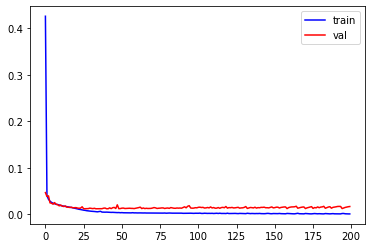

In [21]:
train_loss = np.load(f"{WEIGHT_PATH}/train_loss.npy")
val_loss = np.load(f"{WEIGHT_PATH}/val_loss.npy")

plt.plot(train_loss, color="blue", label="train")
plt.plot(val_loss, color="red", label="val")
plt.legend()
plt.show()